# Data Processing Template
This notebook was used to download, analyze and process the data from the NOAA Pudget Sound dataset.

You can use this template to process your own dataset.

In [32]:
import matplotlib.pyplot as plt
import supervision as sv
from pathlib import Path
import random

## Download the Data
- If you want to use the `unzip` command you might need to install it. On linux, run `sudo apt-get install unzip`

In [3]:
dataset_shortname = "noaa_pudget"
data_dir = Path("/mnt/data/tmp/") / dataset_shortname
data_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
data = "https://storage.googleapis.com/public-datasets-lila/noaa-psnf/noaa_estuary_fish-images.zip"
annotations = "https://storage.googleapis.com/public-datasets-lila/noaa-psnf/noaa_estuary_fish-annotations-2023.08.19.zip"

data_path = data_dir / "images.zip"
annotations_path = data_dir / "annotations.zip"

!wget -O {data_path} {data}
!wget -O {annotations_path} {annotations}

!unzip {data_path} -d {data_dir}
!unzip {annotations_path} -d {data_dir}

!rm {data_path}
!rm {annotations_path}


In [5]:
annotations_path = data_dir / "noaa_estuary_fish-2023.08.19.json"
images_path = data_dir / "JPEGImages"

### Clean the annotations
Turn into COCO format readable by `supervision` library, for easy visualization and conversion to other formats.
- annotations.json only contains annotations for images with at least one bounding box

In [13]:
import json

with open(annotations_path, "r") as f:
    annotations = json.load(f)
    
cleaned_annotations = []
    
print(f"Number of annotations: {len(annotations['annotations'])}")
    
for i, annotation in enumerate(annotations["annotations"]):
    if "bbox" not in annotation or len(annotation["bbox"]) == 0:
        print(f"No bbox found for {annotation['image_id']}")
    else:
        cleaned_annotations.append(annotation)

annotations["annotations"] = cleaned_annotations

with open(annotations_path, "w") as f:
    print(f"Number of annotations: {len(annotations['annotations'])}")
    json.dump(annotations, f)


Number of annotations: 67990
Number of annotations: 67990


## Visualise
To visualise we need to extract the frames from the video, therefore, pick only one video to analyse


In [6]:
dataset = sv.DetectionDataset.from_coco(
    images_directory_path=str(images_path),
    annotations_path=str(annotations_path),
)

print(f"Dataset length: {len(dataset)}")
print(f"Dataset classes: {dataset.classes}")

Dataset length: 77689
Dataset classes: ['empty', 'fish', 'crab', 'fish_or_crab', 'unknown']


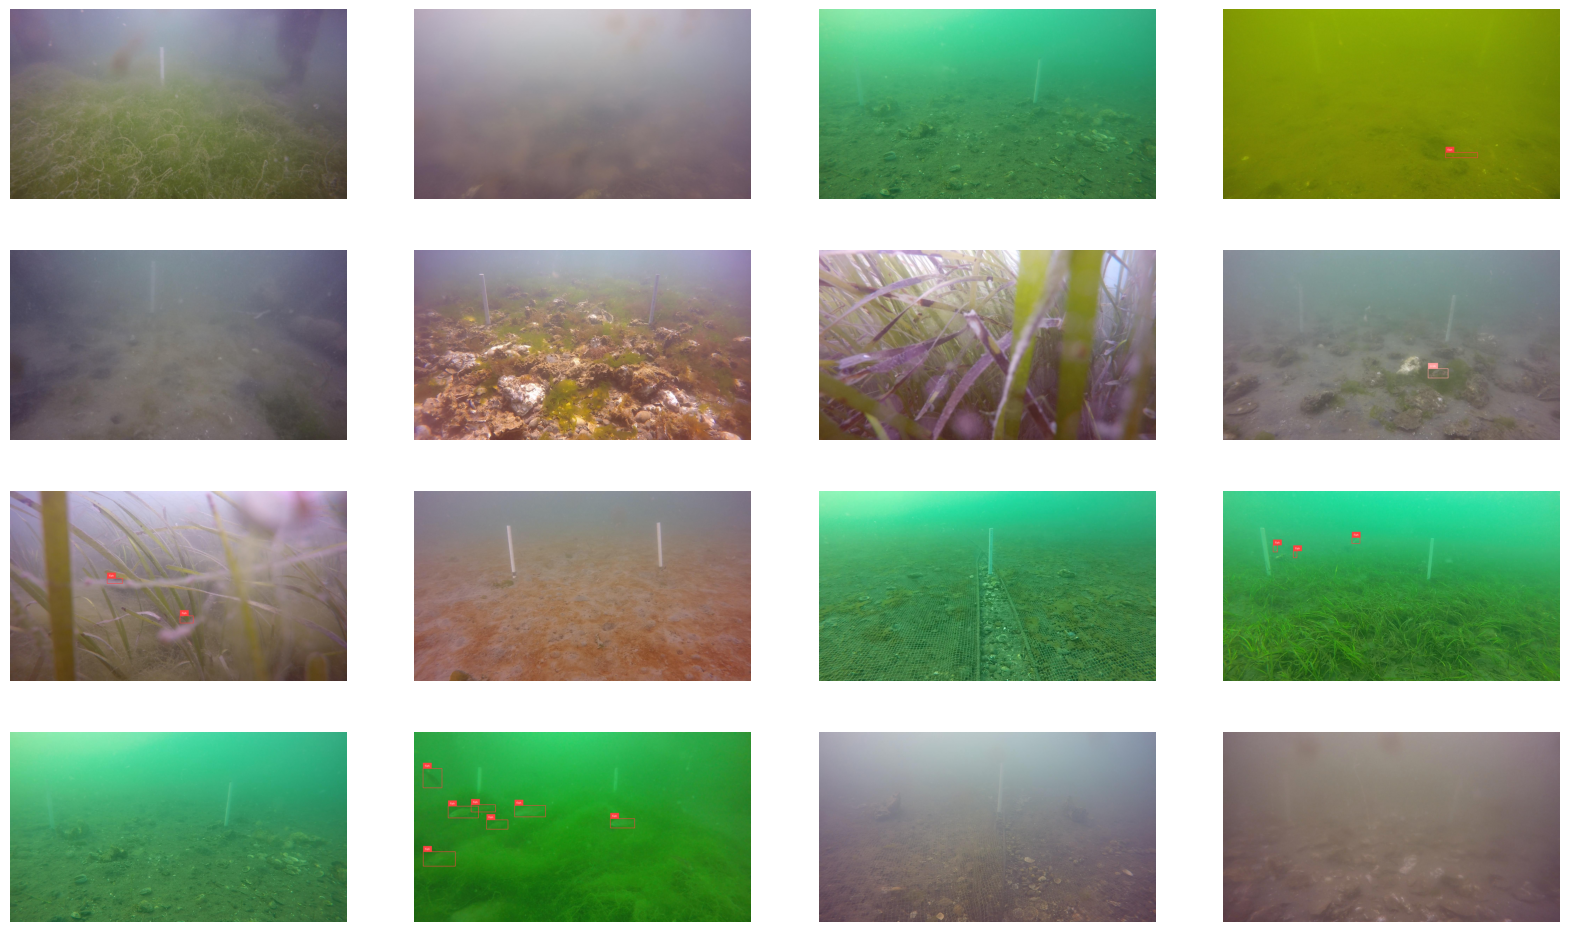

In [34]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

image_example = None

annotated_images = []
for _ in range(16):
    i = random.randint(0, len(dataset))
    
    _, image, annotations = dataset[i]

    labels = [dataset.classes[class_id] for class_id in annotations.class_id]

    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels)
    annotated_images.append(annotated_image)
    
    if len(annotations) > 0:
        image_example = annotated_image
    
sv.plot_images_grid(
    annotated_images,
    grid_size=(4, 4),
    titles=None,
    size=(20, 12),
    cmap="gray"
)

plt.imsave(f"data_preview/{dataset_shortname}_sample_image.png", image_example)


## Save Output
- Save example image
- Save notebook to visualize the image